# Model selection

Previously, we saw the basic recipe for applying a supervised machine learning model:

1. Choose a feature representation of the data
1. Choose a class of algorithm/model
1. Choose model hyperparameters (things like $\lambda$ for L2 normalization, C for an SVM, k for k-NN)
1. Fit the model to the training data
1. Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively.

In order to make an informed choice, we need a way to *validate* that our features, model, and hyperparameters are a good fit to the data.
While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

Things get even more complicated when we are selecting more than one of these things (features, model, hyperparameters) at once on limited amounts of data. Or when our dataset has imbalanced classes (e.g., many more healthy people than cancer patients)

Let's start by working with our old friend, polynomial regression using OLS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white") # plot formatting
%config InlineBackend.figure_format ='retina'

# toy data ~ randomly sampled underlying asymptotic function + gaussian noise 
def true_func(X):
  return 10 - 1. / (X.ravel() + 0.1)

def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = true_func(X)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

Let's introduce you to a _pipeline_, a scikit-learn method to put together a bunch of functions into a single learning algorithm. You can see the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Remember our old way of doing the Polynomial Regression with OLS? We had to do each step explicitly:

```python
feature = PolynomialFeatures(degree=9)
X_train = feature.fit_transform(x_train)
X_predict = feature.fit_transform(x_predict)
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_predict = model.predict(X_predict)
```

The pipeline below allows us to construct it in a single call. 

```python
model = PolynomialRegression(degree=9, fit_intercept=False).fit(x_train, y_train)
y_predict = model.predict(x_predict)
```
Making a complicated algo into a single function is very helpful in scikit-learn.  It allows us to take advantage of handy scikit-learn methods that take a single argument, like cross-validation & learning curves.  Without this utility we would have to code a custom cross-validation loop for every single crazy algo we thought up.


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [ ]:
X, y = make_data(40,rseed=1234)

x_true = np.linspace(0, 1, 100).reshape(-1, 1) #  some x-vals so we can generate true y-vals
y_true = true_func(x_true)

plt.scatter(X, y, s=50, label="training data")
plt.plot(x_true, y_true, label="generating function")

for degree in [1, 3, 12]:
    y_predict = PolynomialRegression(degree,fit_intercept=False).fit(X, y).predict(x_true)
    plt.plot(x_true.ravel(), y_predict, label='degree={0}'.format(degree))

plt.ylim(-1, 14)
plt.legend()
plt.title('Underfit (d=1), well fit, and overfit (d=12) models');
sns.despine()

Let me remind you of the method we used in a previous lecture to do cross-validation.  A handy function called KFold() produces iterative splits of the data according to your needs...



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

k_fold = KFold(n_splits=5)
model = PolynomialRegression(3,fit_intercept=False)

# collect the predicted y values and true y values of each hold out set
predicteds=[]
trueys=[]
for train, holdout in k_fold.split(X, y):
    model.fit(X[train],y[train])
    predicteds.append( model.predict(X[holdout]) )
    trueys.append( y[holdout] )

# this is because we ended up with a list of arrays
predicteds = np.array(predicteds)
trueys = np.array(trueys)

print('Validation error (MSE) across all folds', mean_squared_error(trueys.flatten(),predicteds.flatten()) )

print('Validation error (MSE) in each of the 5 folds seperately')
for p, t in zip(predicteds,trueys):
  print(mean_squared_error(t,p))


Did I hear someone say there has to be an easier way?

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# turn a metric function into a scorer class
mse_scorer = make_scorer(mean_squared_error)

# do it
cross_val_score(model, X, y, cv=5, scoring=mse_scorer)

# Visualizing simple hyperparameter searches

Introducing validation curves, a cute way to visualize what varying a hyperparameter will do to the algorithms performance.

This function cross-validates an sklearn estimator (any kind of classifier or regression or pipeline of those things) on the data; but it does this with multiple different hyperparameter settings. Then it plots both the training set and validation set (hold out fold) performance against the parameter values it tried.

So if you pass it 15 parameter settings and 5 fold validation it runs 15x5 validation runs. Then you can calculate and plot the median (or mean or whatever) performance level of the 5 folds per parameter setting.

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score

degree = np.arange(0, 16)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=5, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'r2' # uses R-squared... 1 is perfect, below 0 is worse than guessing mean of training set y-values
                                         )

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(-.25, 1.25)
plt.xlabel('degree')
plt.ylabel('score');
sns.despine()

Pop quiz #1:

What parameter setting above do you expect to have the best generalization to new data?

What parameter setting has the best training set performance? 

If the best training set performance setting isn't the best generalizer, why is that?

Answers to quiz #1 can be found in our previous lecture on data splitting

Pop quiz #2:

What is the "score" above? What other options are available there? What happens if you leave the scoring parameter blank? Is the default scoring method different for different scikit-learn algorithms? Answers to these questions can be found hidden cleverly in 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html?highlight=validation%20curve#sklearn.model_selection.validation_curve


https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Bonus method to give you a sense of the range across the validation folds, instead of just plotting the central tendancy as above:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py



# Learning curves
Now sometimes you might be interested in knowing "how many data samples do I need to make a decent classifier?" The answer to this question is dependant on many things, including the algorithm, its hyperparameters, and the data.

So as you might imagine, if you want to fit a more complicated overfitting-prone model, you would find poor generalization performance if you don't have enough data.  Random chance will give you overfitting wiggles since it's a high variance model.  But if you use more data, then things can still come out OK as the model gets enough info to restrict its wiggling.

Let's introduce learning_curve() helper function to find out how polynomial degree affects our data sample needs. It will run each fold of the cross-validation on different random subsamples of the total training data. The reported value is the median across folds at that particular subsample size.

Thus we have an estimate of how much training data we need for simple D=2 vs complex D=9 models

In [ ]:
from sklearn.model_selection import learning_curve

#MOAR data, bigger data
X2, y2 = make_data(50)
plt.scatter(X2.ravel(), y2);
plt.title('Now we have 50 data points')
sns.despine()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X2, y2, cv=5,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')
    sns.despine()

If you wanted to, you can also collect multiple scoring metrics simultaneously during the gridsearch: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html 



# Cross-validation for model selection

In [ ]:
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# lets get some 🐧 data to work with
df = sns.load_dataset('penguins').dropna()

# what we want to predict
y_p = df['species']
df = df.drop(columns='species')

# transform the categorical variables into one hot, 
# z-score the numeric variables
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('zscore', scaler, numerical_columns)])


X_p = preprocessor.fit_transform(df)



In [ ]:
%%time
#import warnings
# there are a lot of convergence warnings for some params, however be careful with this!!
# sometimes you need to see those wanrings, and now we've screwed tha tup for the whole notebook from here on!!
#warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create a pipeline 
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]


# Create grid search 
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model = clf.fit(X_p, y_p)

# below we will get a bunch of warnings if some hyperparameters settings don't converge

In [ ]:
best_model.estimator.get_params()

In [ ]:
# the detailed results of the whole model selection search...
best_model.cv_results_
# hmmm... how could you pull stuff out of these results to make some pretty graphs?

# you might want to take a look at the lin

In [ ]:
best_model.cv_results_['rank_test_accuracy']

In [ ]:
 best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

In [ ]:
p = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]
p

In [ ]:
p = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]
pipe.set_params(**p)

In [ ]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

# get rid of classifier__XX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results





---
Acknowledgements: This notebook is a hodgepodge of my work plus stuff from open source notebooks by Jake Van Der Plas, Sebastian Rashkha, and Chris Albon. If you don't pay attention to these people on the interwebs you should.



Now k-fold cross-validation by itself is a good-enough method of model selection. It is pretty efficient at using the data, so it can handle small-ish data tasks. It is pretty unbiased, especially when you use k around 5 or 10 for datasets with several hundred samples. 

But there are several important refinements we may need to make, depedending on the situation.

Varma and Simon found that the nested cross-validation approach can reduce the bias, compared to regular k-fold cross-validation when used for both hyperparameter tuning and evaluation:  "A nested CV procedure provides an almost unbiased estimate of the true error" (Varma and Simon, *BMC bioinformatics*, 7(1):91, 2006).

The method of nested cross-validation is relatively straight-forward as it merely is a nesting of two k-fold cross-validation loops: the inner loop is responsible for the model selection, and the outer loop is responsible for estimating the generalization accuracy, as shown below. 



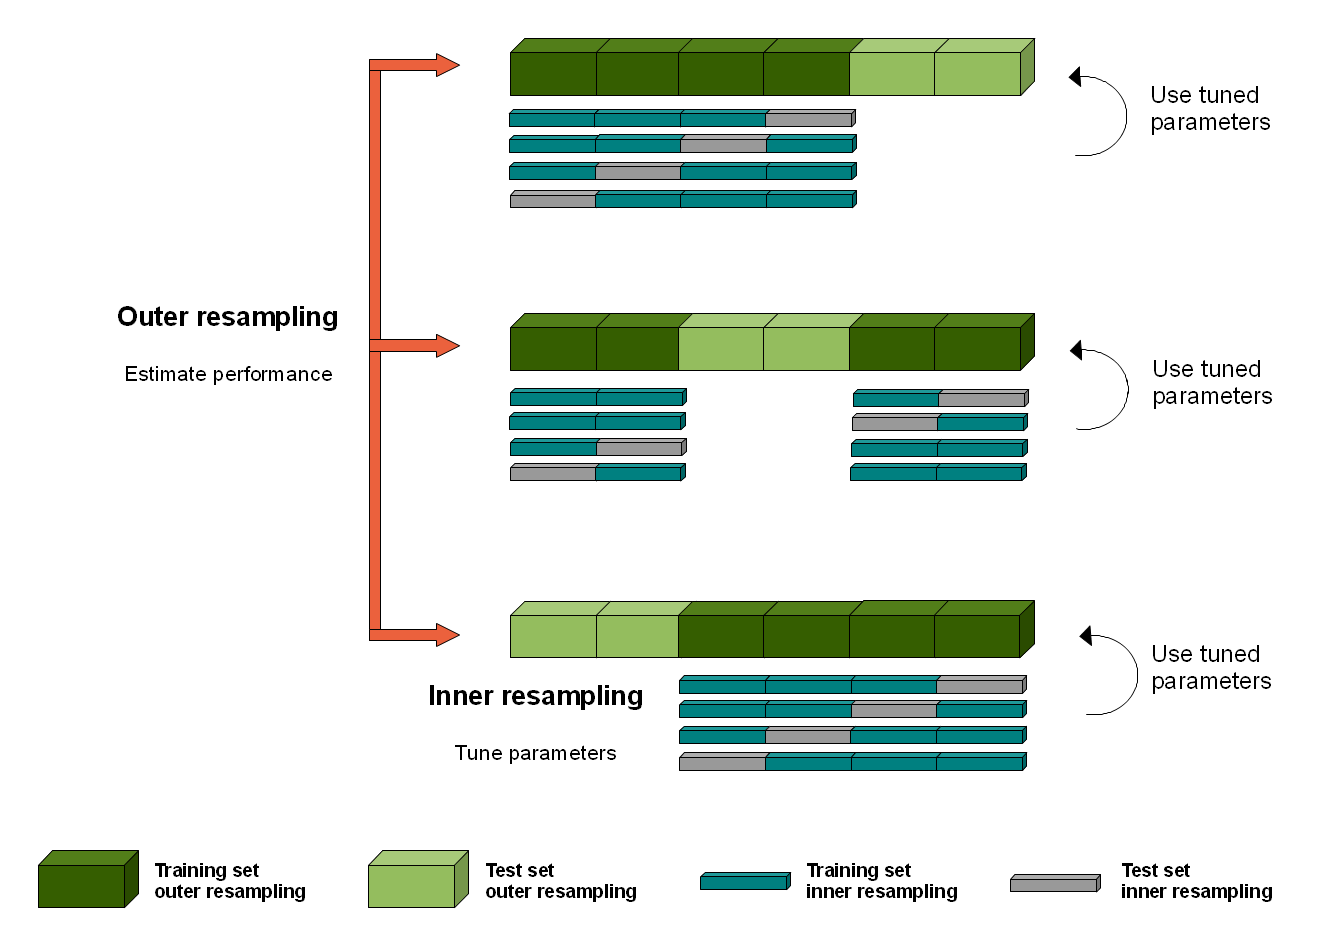



NB: This is one of MANY methods for trying to squeeze every drop of information out of small sample data and produce optimal estimates of generalization for model selection. As I said above plain old X-val is often "good enough". 

If you'd like to see a nice discussion of other methods for optimizing model selection, take a look at https://arxiv.org/abs/1811.12808 which are lecture notes for a class similar to this one that goes more in depth on this matter.

In the meantime, let's see just how much better nested is than regular x-val at this dataset

In [ ]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Number of random trials
NUM_TRIALS = 20


# Set up possible values of parameters to optimize over
# this is a regularization parameter, smaller C => more regularization
p_grid = {"C": [1, 10, 100,  1000]}

# We will use a Logistic Regression
logreg =  LogisticRegression(max_iter=5000, random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=logreg, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_p, y_p)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_p, y=y_p, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(1, 0, 0, .8)) #(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation predicting penguin species from measurements",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(1, 0, 0, .8))
plt.ylabel("score difference", fontsize="14")

plt.show()


In [ ]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression



# Number of random trials
NUM_TRIALS = 20

# Set up possible values of parameters to optimize over
# this is a regularization parameter, smaller C => more regularization
p_grid = {"C": [1, 10, 100,  1000]}

# We will use a Logistic Regression
logreg =  LogisticRegression(max_iter=5000, random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=logreg, param_grid=p_grid, cv=inner_cv, n_jobs=-1)
    clf.fit(X_p, y_p)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_p, y=y_p, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(1, 0, 0, .8)) #(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation predicting penguin species from measurements",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(1, 0, 0, .8))
plt.ylabel("score difference", fontsize="14")

plt.show()


As you can see above, nested consistently estimates generalization performance about 1% lower than regular cross validation on this data/algorithm combo.  And that is due to less optimistic bias... that is, when we see new data, the nested cross-val is more likely than cross-vla to be closer to the true test set performance.

# Stratification

One more possible complication that can occur when your have imbalanced classification problems:

In [ ]:
df.groupby('species').count()['island'].rename('count')

As you randomly shuffle data for making the folds of the cross-validation, you can end up with folds that under- or over- represent a given class as compared to the training data.  Imagine,that randomly a fold ends up with only 5% of the samples being Chinstrap penguins, and all of those are female. In that case this classifier might be terrible at recognizing Chinstraps in general and males in particular.  So the estimate of generalization performance is now going to be much worse than it might otherwise be.

To address problems like this we can force the folds to have the SAME % of each class as the overall training data using StratifiedKFold as shown below:


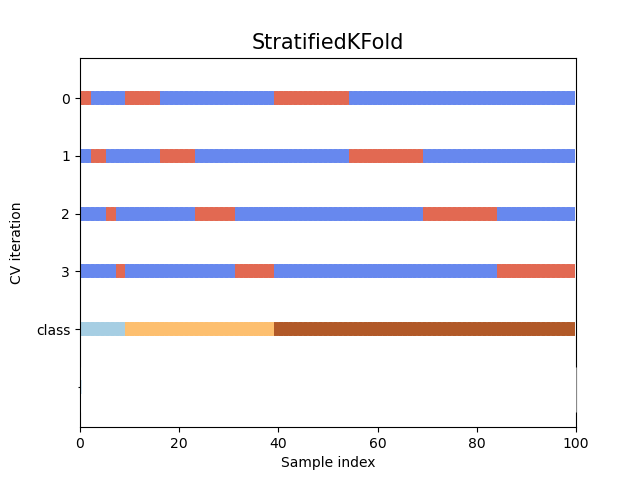

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression 

results1 = cross_val_score( LogisticRegression(max_iter=5000, random_state=21, penalty='none'), 
                           X_p, y_p, cv=KFold(n_splits=10, random_state=747, shuffle=True))
results2 = cross_val_score( LogisticRegression(max_iter=5000, random_state=21, penalty='none'), 
                           X_p, y_p, cv=StratifiedKFold(n_splits=10, random_state=747, shuffle=True))

results = pd.DataFrame({'Regular': results1, 'Stratified': results2})
results

In [ ]:
results.describe()

In [ ]:
sns.pairplot(df,hue='species')

Stratified CV reduces the variability between 
folds in half!  You will likely see a difference in performance mean/median as well. 

So, if we assume that our dataset is a REPRESENTATIVE SAMPLE of the true population, then we should use the Stratified K-fold to get the best estimate of generalization performance.   

Pop quiz: What if the class imbalance doesn't truly reflect the population, it's just an artifact of the dataset? What should we do if we do know the real class balance? E.g. our population is people in the US and we know it's pretty close to 50/50 sex ratio... but our data is 65% male. What can we do to alleviate this problem? 

# Model selection

What if you want to make a grid search where we don't waste time on bogus runs or cause errors?

For instance, SVM's with a polynomial kernel need to be tried for different parameters of ```degree``` and RBF kernels need to be tried for different parameters of ```gamma```.  But it's a waste of computing power to run a bunch of searches for RBF kernels that vary ```degree``` or searches for polynomial kernels that vary ```gamma```

Likewise some solvers allow you to do some regularization penalties and not others. So if you want to avoid error messages don't ask a solver to do something it can't while still asking it of the ones that can.

Here's one way to do that quickly with a minimum of code. You just setup the search space to be a list of parameter grids that cover all the combos you need covered.